Model loaded successfully.
+---------+--------+-------------------+-------------------+--------------------+------------------+------------------+--------------------+--------------------+-------------------+---+--------------------+--------------------+--------------------+---+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+-------------------+------------------+----+------------------+--------------------+-------------------+--------------------+-----------------+----+----+-----+---+----+-----------------------+------------------------+--------------------+--------------------+--------------------+------------------+
|longitude|latitude|               time|                u10|                 v10|               d2m|               t2m|                  cp|                   e|                hcc|cvh|              lai_hv|              lai_lv|           

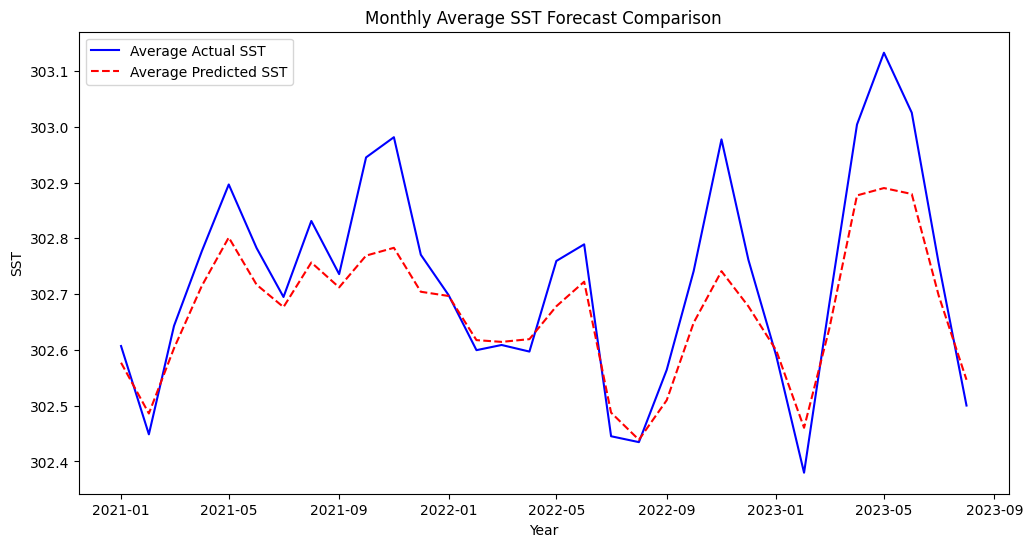

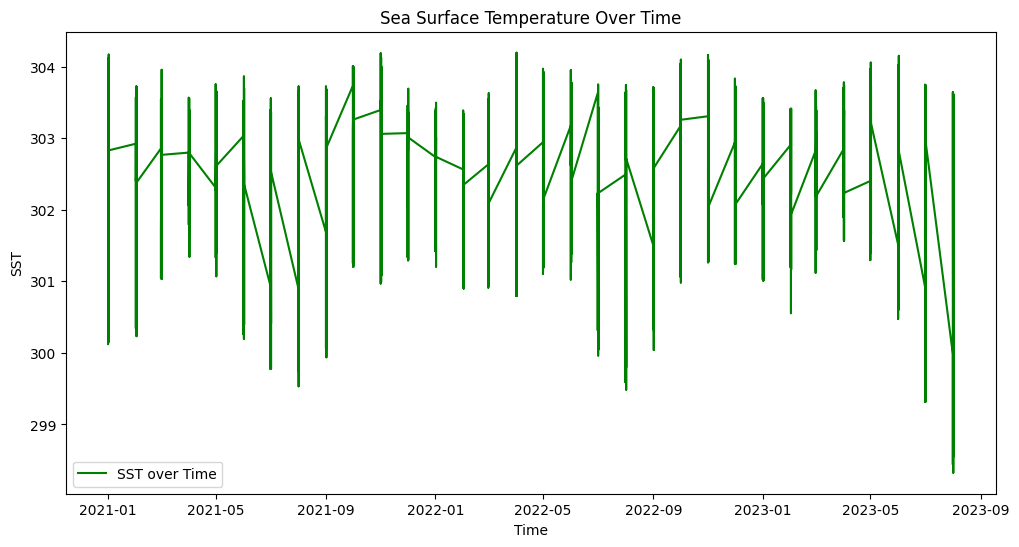

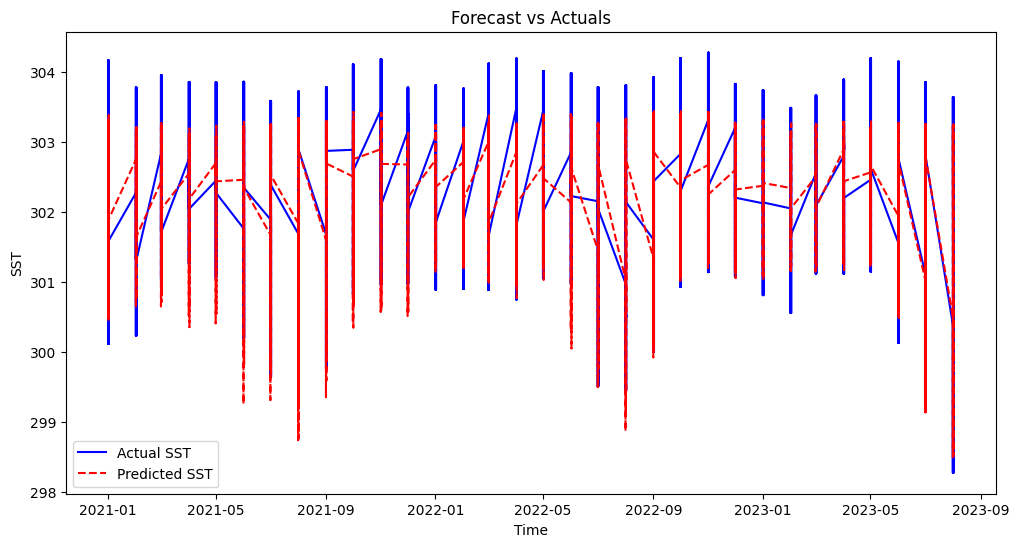

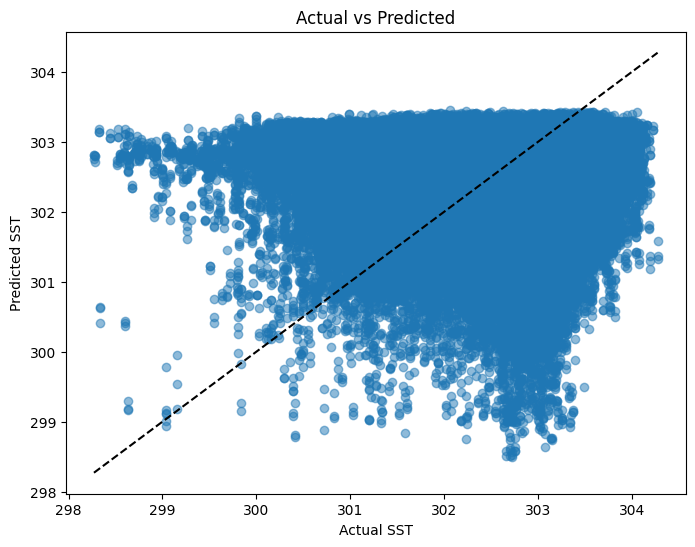

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col, to_timestamp, year, month, day, hour, last, first, coalesce, date_format, avg, when
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, RobustScaler
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Create Spark session
spark = SparkSession.builder.appName("SSTPrediction").getOrCreate()

# Load the model
model_path = 'RF_SST_PRED_model'  # Replace with your actual model path
loaded_model = PipelineModel.load(model_path)
print("Model loaded successfully.")

# Load the sample data
sample_data = "testing_chunk.csv"
df = spark.read.csv(sample_data, header=True, inferSchema=True)

# Filter test data
split_year_test = 2021
df = df.filter(year(df['time']) >= split_year_test).cache()

# Convert time column to timestamp and add time-based features
df = df.withColumn("time", to_timestamp("time")).orderBy("time", "latitude", "longitude")
df = df.withColumn("year", year("time"))
df = df.withColumn("month", month("time"))
df = df.withColumn("day", day("time"))
df = df.withColumn("hour", hour("time"))

# Define window specifications for lag features
windowSpec = Window.partitionBy("latitude", "longitude").orderBy("time")

# Adding initial lag features; stepsize :3
df = df.withColumn("sst_lag_3_months", lag("sst", 9).over(windowSpec))
df = df.withColumn("sst_lag_12_months", lag("sst", 36).over(windowSpec))

# Define window specifications for forward and backward fill
windowSpecForward = Window.partitionBy("latitude", "longitude").orderBy("time").rowsBetween(Window.unboundedPreceding, Window.currentRow)
windowSpecBackward = Window.partitionBy("latitude", "longitude").orderBy(col("time").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Applying forward fill using last and backward fill using first, but only filling nulls

#For sst_lag_3_months
df = df.withColumn("sst_lag_3_months_ffill", when(col("sst_lag_3_months").isNull(), last("sst_lag_3_months", ignorenulls=True).over(windowSpecForward)).otherwise(col("sst_lag_3_months")))
df = df.withColumn("sst_lag_3_months_filled", when(col("sst_lag_3_months_ffill").isNull(), first("sst_lag_3_months_ffill", ignorenulls=True).over(windowSpecBackward)).otherwise(col("sst_lag_3_months_ffill")))

# For sst_lag_12_months
df = df.withColumn("sst_lag_12_months_ffill", when(col("sst_lag_12_months").isNull(), last("sst_lag_12_months", ignorenulls=True).over(windowSpecForward)).otherwise(col("sst_lag_12_months")))
df = df.withColumn("sst_lag_12_months_filled", when(col("sst_lag_12_months_ffill").isNull(), first("sst_lag_12_months_ffill", ignorenulls=True).over(windowSpecBackward)).otherwise(col("sst_lag_12_months_ffill")))

# Drop unnecessary columns
df = df.drop("sst_lag_3_months", "sst_lag_3_months_ffill", "sst_lag_12_months", "sst_lag_12_months_ffill")

# Filter out rows with null values in the filled lag columns
test_data = df.na.drop(subset=["sst_lag_12_months_filled"])

# Feature Engineering - RobustScaler and VectorAssembler
# features to scale
initial_feature_cols = [col for col in test_data.columns if col not in ["time", "sst", "longitude", "latitude"]]
initial_assembler = VectorAssembler(inputCols=initial_feature_cols, outputCol="initial_features")

# Robust scaler
scaler = RobustScaler(inputCol="initial_features", outputCol="scaled_features")

# Assemble final feature columns including scaled features, longitude, and latitude
final_assembler = VectorAssembler( inputCols=["longitude","latitude","scaled_features"],outputCol="features" )

# Use the loaded model for prediction
predictions = loaded_model.transform(test_data)
predictions.show()

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="rmse")
evaluator1 = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="mae")
evaluator2 = RegressionEvaluator(labelCol="sst", predictionCol="prediction", metricName="r2")

rmse = evaluator.evaluate(predictions)
mae = evaluator1.evaluate(predictions)
r2 = evaluator2.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error:", mae)
print("R2 score:", r2)

# Visualization
# Aggregate predictions by day for visualization
predictions_agg = predictions.groupBy(date_format('time', 'yyyy-MM-dd').alias('year')).agg(
    avg('prediction').alias('avg_prediction'),
    avg('sst').alias('avg_actual_sst')
).orderBy('year')

predictions_monthly_pd = predictions_agg.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(predictions_monthly_pd['year']), predictions_monthly_pd['avg_actual_sst'], label='Average Actual SST', color='blue')
plt.plot(pd.to_datetime(predictions_monthly_pd['year']), predictions_monthly_pd['avg_prediction'], label='Average Predicted SST', color='red', linestyle='--')
plt.title('Monthly Average SST Forecast Comparison')
plt.xlabel('Year')
plt.ylabel('SST')
plt.legend()
plt.show()


# Assuming you've filtered or sampled the data appropriately
data_sample_pd = test_data.select("time", "sst").orderBy("time").sample(fraction=0.1).toPandas()  # Sample if the data is too large

plt.figure(figsize=(12, 6))
plt.plot(data_sample_pd['time'], data_sample_pd['sst'], label='SST over Time', color='green')
plt.title('Sea Surface Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('SST')
plt.legend()
plt.show()

# Collect data from PySpark to local Python for plotting
predictions_pd = predictions.select("time", "prediction").orderBy("time").toPandas()
test_data_pd = test_data.select("time", "sst").orderBy("time").toPandas()

# Plotting the forecast graph
plt.figure(figsize=(12, 6))
plt.plot(test_data_pd['time'], test_data_pd['sst'], label='Actual SST', color='blue')
plt.plot(predictions_pd['time'], predictions_pd['prediction'], label='Predicted SST', color='red', linestyle='--')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('SST')
plt.legend()
plt.show()

# Plotting Actual vs. Prediction
plt.figure(figsize=(8, 6))
plt.scatter(test_data_pd['sst'], predictions_pd['prediction'], alpha=0.5)
plt.title('Actual vs Predicted')
plt.xlabel('Actual SST')
plt.ylabel('Predicted SST')
plt.plot([test_data_pd['sst'].min(), test_data_pd['sst'].max()], [test_data_pd['sst'].min(), test_data_pd['sst'].max()], 'k--')
plt.show()
